In [1]:
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fftpack
import random
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
from mfilter.regressions import * #here it is the regression
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Noise Variance
The Matched Filter is an special type of linear filter where the output of the filter is normalized by the square root of the variance of the noise of the detector (input signal). Then it is important to understand how to calculate this quatity for unevenly time samples. There are two implementations of the Matched Filter, one is direct and the other one use a whitening filter.


### Matched Filter fo White Noise
First we are going to think in the normal Matched Filter without whitening considering a white noise. In this case the variance is:

$$ \sigma^2 = N_0 \int_{-\infty}^{-\infty} |\tilde{h}(f)|^2 df $$

Where $N_0$ represent the PSD of the white noise. This one-sided PSD theoretically is $N_0 = \sigma ^ 2 / N$ where $N$ is te total number of samples. Here we check that for all white noise, in any template, the amplitude of the SNR will be around 1.


freq: 100
expected value of amplitude SNR is, for regular: 15.527117621722043 and irregular: 10.044946128406432
sigma of real part SNR is, for regular: 12.47704324953057 and irregular: 8.096534429901682


Text(0.5,1,'Amplitude SNR for pure noise when $\\sigma_{noise}=$28.43, and for N=100 repetitions')

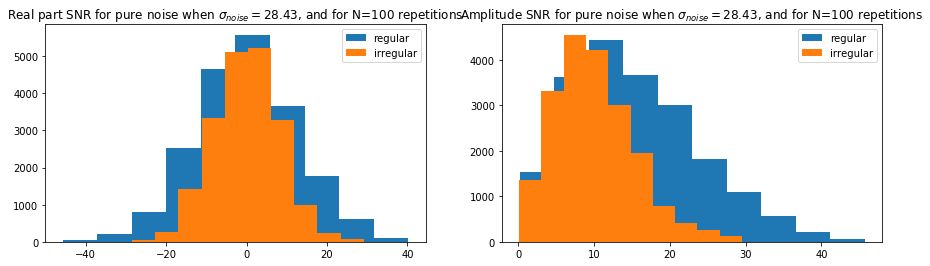

In [2]:
'''
Calculate the frequency grid
'''
def f_grid(t, gamma=1, f_max=None):
    f_min = 1/t.duration
    df = f_min / gamma
    if f_max is None:
        f_max = 0.5 * t.average_fs
    return FrequencySamples(input_time=t, minimum_frequency=f_min, maximum_frequency=f_max,
                            samples_per_peak=gamma)

'''
variables
'''
sqvar = 28.43
n_repeat = 100

N = 200
basic_dt = 0.00007
times1 = TimesSamples(n=N, delta=basic_dt, struct="automix")
times2 = TimesSamples(n=N, delta=basic_dt, struct="normal")
times1 -= times1[0]

freq_sin = 100
print("freq:", freq_sin)
Factor = 3
temp1 = np.sin(2 * np.pi * freq_sin * times1)
temp1 += 3 * np.sin(2 * np.pi * freq_sin * Factor * times1)

temp2 = np.sin(2 * np.pi * freq_sin * times2)
temp2 += 3 * np.sin(2 * np.pi * freq_sin * Factor * times2)

T1 = TimeSeries(temp1, times=times1)
T2 = TimeSeries(temp2, times=times2)

f_max = 3 * Factor * freq_sin
gamma = 1
# f_max = None
f1 = f_grid(times1, gamma=gamma, f_max=f_max)
f2 = f_grid(times2, gamma=gamma, f_max=f_max)

# define regressor
reg = SGDRegression(alpha=10**(-4), max_iter=100)
reg.reset()
reg.create_dict(times1, f1)
FT1 = T1.to_frequencyseries(reg=reg)
reg.reset()
reg.create_dict(times2, f2)
FT2 = T2.to_frequencyseries(reg=reg)

N0 = sqvar**2/(2*f1.sum())
sigma1 = N0 * (np.abs(FT1)**2).sum()
sigma2 = N0 * (np.abs(FT2)**2).sum()
regular = []
irregular = []

for i in range(n_repeat):
    noise = np.random.normal(0, sqvar, N)

    N1 = TimeSeries(noise, times=times1)
    N2 = TimeSeries(noise, times=times2)

    reg.reset()
    reg.create_dict(times1, f1)
    FN1 = N1.to_frequencyseries(reg=reg)
    reg.reset()
    reg.create_dict(times2, f2)
    FN2 = N2.to_frequencyseries(reg=reg)

    # times1
    sigma1 = N0 * (np.abs(FT1)**2).sum()

    corrN1 = FN1
    corrN1 *= FT1.conj()
    corrN1 /= np.sqrt(sigma1)


    corrN2 = FN2
    corrN2 *= FT2.conj()
    corrN2 /= np.sqrt(sigma2)

    reg.reset()
    reg.create_dict(times1, f1)
    MFN1 = corrN1.to_timeseries(reg=reg)
    reg.reset()
    reg.create_dict(times2, f2)
    MFN2 = corrN2.to_timeseries(reg=reg)
    regular.extend(MFN2)
    irregular.extend(MFN1)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 4)) 
ax1.hist(np.real(regular), label="regular")
ax1.hist(np.real(irregular), label="irregular")
ax1.legend()
ax2.hist(np.abs(regular), label="regular")
ax2.hist(np.abs(irregular), label="irregular")
ax2.legend()
print(r"expected value of amplitude SNR is, for regular:", np.mean(np.abs(regular)), 
      "and irregular:", np.mean(np.abs(irregular)))
print("sigma of real part SNR is, for regular:", np.std(np.real(regular)), 
      "and irregular:", np.std(np.real(irregular)))
ax1.set_title(r"Real part SNR for pure noise when $\sigma_{noise}=$" + str(sqvar)  
          + ", and for N=" + str(n_repeat) +" repetitions")
ax2.set_title(r"Amplitude SNR for pure noise when $\sigma_{noise}=$" + str(sqvar)  
          + ", and for N=" + str(n_repeat) +" repetitions")


### Matched Filter for Colored Noise
Then we need to check if this property of the matched filter it is still valid when we use the whitening filter. In theory, add a whitening filter to the matched filter should works exactly the same way, but the form is different, here the variance is:

$$\sigma^2 = N_0^2\int_{-\infty}^{-\infty} \frac{|\tilde{h}(f)|^2}{PSD_{noise}(f)} df $$ 

and the SNR is:

$$ \rho(t_0) = \frac{N_0 \int_{-\infty}^{-\infty} \frac{\tilde{x}(f)\tilde{h}^{*}(f)e^{2\pi f t_0}}{PSD_{noise}(f)} df}{\sigma} $$

If we think of a white noise instead of colored we get again the previous version of the Matched Filter. But here the idea si to estimate the PSD of the noise even if is in theory white noise and check that the results are good.

In practice we should estimate the noise PSD from the input data using algorithm like lomb-welch periodogram, but since we have the true noise used in the singal we can directly calculate the PSD of the noise.

In the last formula for $\sigma$ we use a $N_0 $ which is not the same as the noise PSD, in this case $N_0$ is the PSD of the desired white noise , means $N_0 = 1/N$ but in the estimation of the SNR this term is not used.

In [3]:
N

200

expected value of amplitude SNR is, for regular: 36.4151319144628 and irregular: 52.40536360146847
sigma of real part SNR is, for regular: 27.497609900708227 and irregular: 55.02951821455873


Text(0.5,1,'Amplitude SNR for pure noise when $\\sigma_{noise}=$28, and for N=100 repetitions')

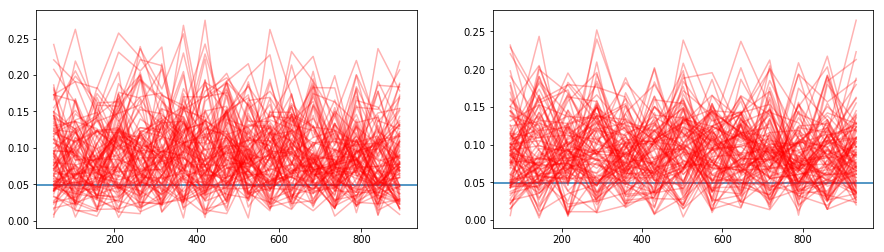

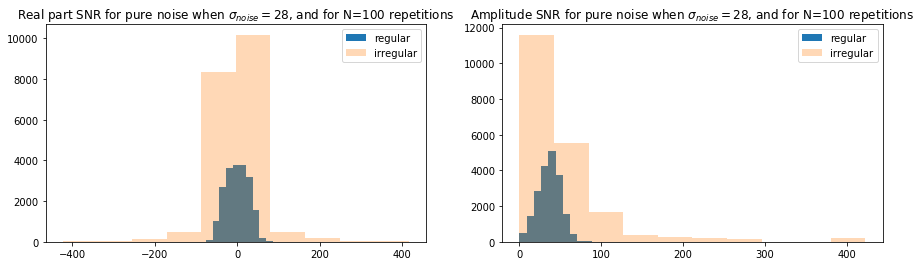

In [4]:

'''
variables
'''
sqvar = 28
n_repeat = 100
norm = "standard"

N0 = sqvar**2/ (2 * f1.sum())
sigma1 = N0 * (np.abs(FT1)**2).sum()
sigma2 = N0 * (np.abs(FT2)**2).sum()
regular = []
irregular = []

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 4))
ax1.axhline(N0)
ax2.axhline(N0)
for i in range(n_repeat):
    noise = np.random.normal(0, sqvar, N)

    N1 = TimeSeries(noise, times=times1)
    N2 = TimeSeries(noise, times=times2)
    psd1 = f1.lomb_scargle(times1, N1, norm=norm, weighted=False)
    psd2 = f2.lomb_scargle(times2, N2, norm=norm, weighted=False)
    ax1.plot(f1, np.sqrt(psd1), 'r', alpha=0.3)
    ax2.plot(f2, np.sqrt(psd2), 'r', alpha=0.3)
    
    sigma1 = ((np.abs(FT1)**2)/psd1).sum()
    sigma2= ((np.abs(FT2)**2)/psd2).sum()
    
    reg.reset()
    reg.create_dict(times1, f1)
    FN1 = N1.to_frequencyseries(reg=reg)
    reg.reset()
    reg.create_dict(times2, f2)
    FN2 = N2.to_frequencyseries(reg=reg)


    corrN1 = FN1
    corrN1 *= FT1.conj()
    corrN1 /= psd1
    corrN1 /= np.sqrt(sigma1)


    corrN2 = FN2
    corrN2 *= FT2.conj()
    corrN2 /= psd2
    corrN2 /= np.sqrt(sigma2)

    reg.reset()
    reg.create_dict(times1, f1)
    MFN1 = corrN1.to_timeseries(reg=reg)
    reg.reset()
    reg.create_dict(times2, f2)
    MFN2 = corrN2.to_timeseries(reg=reg)
    regular.extend(MFN2)
    irregular.extend(MFN1)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 4)) 
ax1.hist(np.real(regular), label="regular")
ax1.hist(np.real(irregular), label="irregular", alpha=0.3)
ax1.legend()
ax2.hist(np.abs(regular), label="regular")
ax2.hist(np.abs(irregular), label="irregular", alpha=0.3)
ax2.legend()
print(r"expected value of amplitude SNR is, for regular:", np.mean(np.abs(regular)), 
      "and irregular:", np.mean(np.abs(irregular)))
print("sigma of real part SNR is, for regular:", np.std(np.real(regular)), 
      "and irregular:", np.std(np.real(irregular)))
ax1.set_title(r"Real part SNR for pure noise when $\sigma_{noise}=$" + str(sqvar)  
          + ", and for N=" + str(n_repeat) +" repetitions")
ax2.set_title(r"Amplitude SNR for pure noise when $\sigma_{noise}=$" + str(sqvar)  
          + ", and for N=" + str(n_repeat) +" repetitions")

In [5]:
'''
Calculate the frequency grid
'''
def f_grid(t, gamma=1, f_max=None):
    f_min = 1/t.duration
    df = f_min / gamma
    if f_max is None:
        f_max = 0.5 * t.average_fs
    return FrequencySamples(input_time=t, minimum_frequency=f_min, maximum_frequency=f_max,
                            samples_per_peak=gamma)

'''
Calculate the autocovarriance and autocorrelation coefficients.
'''
def autocovariance(Xi, N, k, Xs):
    autoCov = 0
    for i in np.arange(0, N-k):
        autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
    return (1/(N-1))*autoCov

def autocorrelation(Xi, N, k, Xs):
    return autocovariance(Xi, N, k, Xs) / 1


def autocorrelation_function(noise, mean_noise, times):
    N  = len(noise)
    function = []
    for i in range(len(times)):
        function.append(autocorrelation(noise, N, i, mean_noise))
    return function

freq: 20


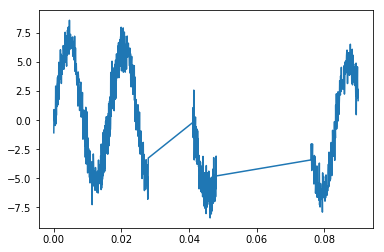

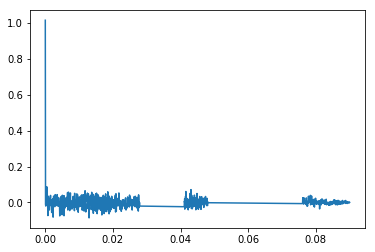

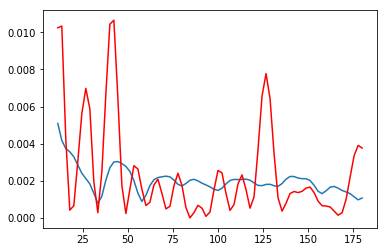

In [17]:
N = 1000
basic_dt = 0.00007
times1 = TimesSamples(n=N, delta=basic_dt, struct="automix")
times2 = TimesSamples(n=N, delta=basic_dt, struct="normal")
times1 -= times1[0]
freq_sin = 20
print("freq:", freq_sin)
Factor = 3
data1 = np.sin(2 * np.pi * freq_sin * times1)
data1 += 3 * np.sin(2 * np.pi * freq_sin * Factor * times1)

data2 = np.sin(2 * np.pi * freq_sin * times2)
data2 += 3 * np.sin(2 * np.pi * freq_sin * Factor * times2)

noise1 = np.random.normal(0, 1, N)
data1 += noise1

plt.figure()
plt.plot(times1, data1)

rxx1 = autocorrelation_function(noise1, np.average(noise1), times1)
plt.figure()
plt.plot(times1, rxx1)
Rxx1 = TimeSeries(np.abs(rxx1), times=times1)
Noise = TimeSeries(noise1, times=times1)

f_max = 3*Factor*freq_sin
# f_max = None
gamma = 5
f1 = f_grid(times1, gamma=gamma, f_max=f_max)
f2 = f_grid(times2, gamma=gamma, f_max=f_max)

real_psd = f1.lomb_scargle(times1, Noise, norm="standard", 
                              windowed=False, weighted=False)

# define regressor
reg = SGDRegression(alpha=10**(-4), max_iter=100)
reg.reset()
reg.create_dict(times1, f1)
Frxx1 = Rxx1.to_frequencyseries(reg=reg)
plt.figure()
plt.plot(f1, np.abs(Frxx1))
plt.plot(f1, np.abs(real_psd), 'r')

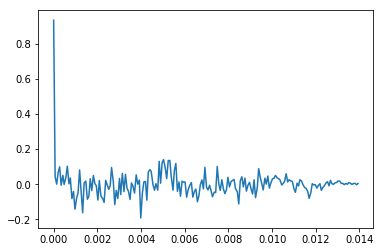

In [7]:


rxx1 = autocorrelation_function(noise1, np.average(noise1), times1)
plt.plot(times1, rxx1)
Rxx1 = TimeSeries(rxx1, times=times1)


From the theory of Matched Filter, we want to normalice our linear filter by the noise variance calculated through:

$$ \sigma^2 = \int_{-\infty}^{-\infty}\int_{-\infty}^{-\infty} h_{w}^{*}(t_1) k(t_1-t_2) h_{w}(t_2) dt_1 dt_2$$

Where $h_{w}(t)$ represent the whitened template used in the linear filter and $k(t_1-t_2)$ is the auto-covariance function of the noise. By _Bochner's Theorem_ whe can consider $k$ as the inverse fourier transform of the spectral density of the noise ($S_n$), only if the auto-covariance function is normalized, then:

$$ \sigma^2 = \int_{-\infty}^{-\infty} \frac{|\tilde{h}_{w}(f)|^{2}}{S_n(f)} df$$